In [1]:
import torch
import torchaudio
import io
import os
import math
import scipy
import librosa
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import IPython.display as ipd

In [6]:
waveform, sample_rate = torchaudio.load('/Users/serenazhang/Documents/cs230/coughvid/valid_data/0a1b2f0a-afa2-42e3-9e60-998c4bdf1f95.wav')
print(waveform, sample_rate)

tensor([[0., 0., 0.,  ..., 0., 0., 0.]]) 48000


In [7]:
def play_audio(waveform, sample_rate):
  #if waveform is a tensor, convert to numpy array
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  print(waveform.shape)
  if num_channels == 1:
    ipd.display(ipd.Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    ipd.display(ipd.Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

play_audio(waveform, sample_rate)

(1, 478080)


In [3]:
metadata = torchaudio.info('/Users/serenazhang/Documents/cs230/coughvid_20211012/0a0b83e9-860d-42ec-855b-49e73c5ad49e.wav')
print(metadata)

AudioMetaData(sample_rate=48000, num_frames=469440, num_channels=1, bits_per_sample=16, encoding=PCM_S)


Adding code audio segmentation.

In [18]:
from segmentation import segment_cough

#wave_np = waveform.numpy()
#print(wave_np.shape)

w_lib, sample_lib = librosa.load('/Users/serenazhang/Documents/cs230/coughvid/valid_data/0a1b2f0a-afa2-42e3-9e60-998c4bdf1f95.wav', sr=48000)
print(w_lib, sample_lib)
print(w_lib.shape)

w_tf, sample_tf = torchaudio.load('/Users/serenazhang/Documents/cs230/coughvid/valid_data/0a1b2f0a-afa2-42e3-9e60-998c4bdf1f95.wav')
print(w_tf, sample_tf)
print(w_tf.shape)
play_audio(w_tf, sample_tf)

#cough_segments, cough_mask = segment_cough(wave_np, sample_rate)

# cough_segments, cough_mask = segment_cough(w_lib, sample_lib)
# print('cough_segments, cough_mask for librosa:', cough_segments, cough_mask)


print('w_tf: ', w_tf)
print('w_tf edited: ', w_tf.numpy()[0])
#cough_1, cough_mask_1 = segment_cough(w_tf[0], float(sample_tf))
#print('cough_segments, cough_mask for tf:', cough_1, cough_mask_1)



cough_tf, cough_mask_tf = segment_cough(w_tf.numpy()[0], float(sample_tf))
#print('cough_segments, cough_mask for tf:', cough_tf, cough_mask_tf)

print('cough_tf: ', cough_tf)
print('cough_mask_tf', cough_mask_tf)

# coughs = torch.tensor(cough_segments)  




for segment in cough_tf:
  print(segment.shape)
  #turn segment into tensor 1 by segment.shape
  segment_tensor = torch.tensor(segment)
  segment_tensor = segment_tensor.unsqueeze(0)
  print('tensor shape: ', segment_tensor.shape)
  #get number of frames in segment
  num_frames = segment_tensor.shape[1]
  #get rate of segment
  rate = num_frames/sample_rate
  #get duration
  duration = rate * 1000
  print(duration)
  play_audio(segment_tensor, sample_rate)


[0. 0. 0. ... 0. 0. 0.] 48000
(478080,)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]]) 48000
torch.Size([1, 478080])
(1, 478080)


w_tf:  tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
w_tf edited:  [0. 0. 0. ... 0. 0. 0.]
cough_tf:  [array([-0.00292969, -0.00372314, -0.00384521, ..., -0.03909302,
       -0.03271484, -0.03103638], dtype=float32), array([ 4.5352173e-01,  4.4021606e-01,  4.0689087e-01, ...,
        1.5258789e-04, -9.1552734e-05, -3.3569336e-04], dtype=float32), array([ 9.1552734e-05,  2.4414062e-04,  3.0517578e-04, ...,
       -9.1552734e-05, -6.1035156e-05, -9.1552734e-05], dtype=float32)]
cough_mask_tf [False False False ... False False False]
(33910,)
tensor shape:  torch.Size([1, 33910])
706.4583333333333
(1, 33910)


(30274,)
tensor shape:  torch.Size([1, 30274])
630.7083333333334
(1, 30274)


(32804,)
tensor shape:  torch.Size([1, 32804])
683.4166666666666
(1, 32804)


Change pitch of all audio files.

Turning all audio into Mel Spectrograms.
Below is the plot spectrogram function.

In [19]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

Below is creating the spectrogram with the pipeline class in nn.module.

In [20]:
# Define custom feature extraction pipeline.
#
# 1. Resample audio
# 2. Convert to power spectrogram
# 3. Apply augmentations
# 4. Convert to mel-scale
#
class MyPipeline(torch.nn.Module):
    def __init__(
        self,
        #input_freq=16000,
        #resample_freq=8000,
        n_fft=1024,
        n_mel=128,
        win_length = None,
        hop_length = 512,
        stretch_factor=0.8,
    ):
        super().__init__()
        #self.resample = Resample(orig_freq=input_freq, new_freq=resample_freq)

        self.spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, center=True, pad_mode="reflect", power=2)

        self.spec_aug = torch.nn.Sequential(
            torchaudio.transforms.TimeStretch(stretch_factor, fixed_rate=True),
            torchaudio.transforms.FrequencyMasking(freq_mask_param=80),
            torchaudio.transforms.TimeMasking(time_mask_param=80),
        )

        self.mel_scale = torchaudio.transforms.MelScale(
            n_mels=n_mel, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Resample the input
        #resampled = self.resample(waveform)

        # Convert to power spectrogram
        spec = self.spec(waveform)

        #plot_spectrogram(spec)

        # Apply SpecAugment
        spec = self.spec_aug(spec)

        # Convert to mel-scale
        mel = self.mel_scale(spec)

        return mel

(1, 478080)


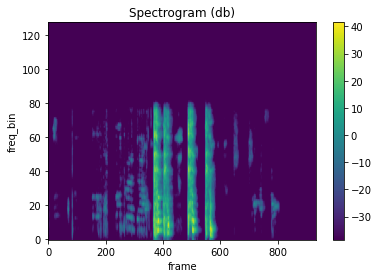

(33910,)
torch.Size([1, 33910])
(1, 33910)


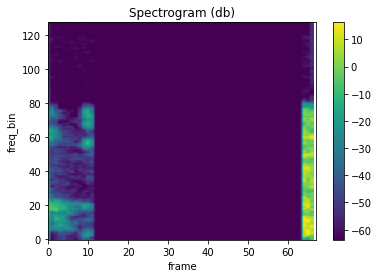

(30274,)
torch.Size([1, 30274])
(1, 30274)


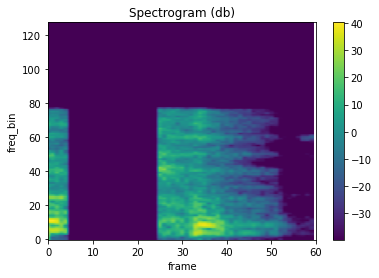

(32804,)
torch.Size([1, 32804])
(1, 32804)


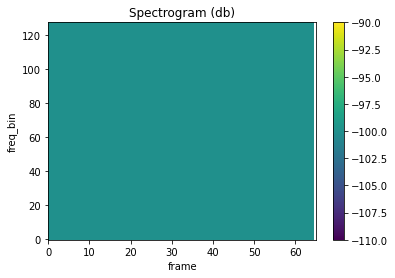

In [24]:
pipeline = MyPipeline()

# Move the computation graph to CUDA
#pipeline.to(device=torch.device("cuda"), dtype=torch.float32)

w_tf, sample_tf = torchaudio.load('/Users/serenazhang/Documents/cs230/valid_data/0a1b2f0a-afa2-42e3-9e60-998c4bdf1f95.wav')
play_audio(w_tf, sample_tf)
features = pipeline.forward(w_tf)
  # Plot the spectrogram
plot_spectrogram(features[0].numpy(), title='Spectrogram (db)', aspect='auto', xmax=features.shape[2])

for segment in cough_segments:
  print(segment.shape)
  #turn segment into tensor 1 by segment.shape
  segment_tensor = torch.tensor(segment)
  segment_tensor = segment_tensor.unsqueeze(0)
  print(segment_tensor.shape)  
  play_audio(segment_tensor, sample_rate)
  # Perform the transform
  features = pipeline.forward(segment_tensor)
  # Plot the spectrogram
  plot_spectrogram(features[0].numpy(), title='Spectrogram (db)', aspect='auto', xmax=features.shape[2])

Below is just using the spectrograms.

(1, 478080)


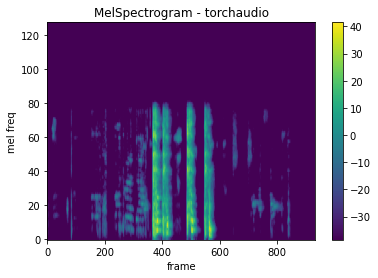

(33910,)
torch.Size([1, 33910])
(1, 33910)


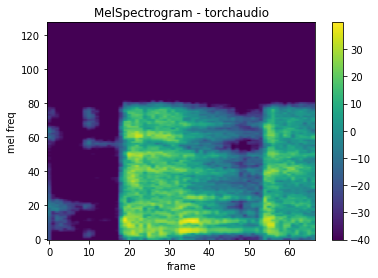

(30274,)
torch.Size([1, 30274])
(1, 30274)


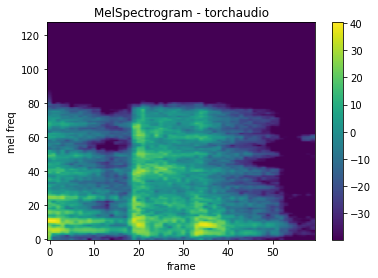

(32804,)
torch.Size([1, 32804])
(1, 32804)


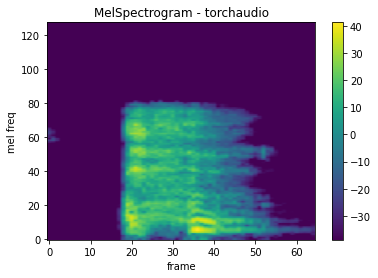

In [23]:
n_fft = 1024
win_length = None
hop_length = 512

# define transformation
# spectrogram = torchaudio.transforms.Spectrogram(
#     n_fft=n_fft,
#     win_length=win_length,
#     hop_length=hop_length,
#     center=True,
#     pad_mode="reflect",
#     power=2.0,
# )




mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

w_tf, sample_tf = torchaudio.load('/Users/serenazhang/Documents/cs230/valid_data/0a1b2f0a-afa2-42e3-9e60-998c4bdf1f95.wav')
play_audio(w_tf, sample_tf)
mel_spec = mel_spectrogram(w_tf)
#plot mel_spectrogram
plot_spectrogram(mel_spec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')

# Perform transformation
for segment in cough_segments:
  print(segment.shape)
  #turn segment into tensor 1 by segment.shape
  segment_tensor = torch.tensor(segment)
  segment_tensor = segment_tensor.unsqueeze(0)
  print(segment_tensor.shape)  
  play_audio(segment_tensor, sample_rate)
  #spec = spectrogram(waveform)
  mel_spec = mel_spectrogram(segment_tensor)
  plot_spectrogram(mel_spec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')

    # Plot the spectrogram

#   print(spec.shape)
#   print(torch.max(spec), torch.mean(spec))

Normalize Mel Spectrogram